<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/field_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysheds
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.2 MB/s eta 0:00:00


In [ ]:
from pysheds.grid import Grid
import rasterio as rio
import geopandas as gpd
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors
from shapely import Point, MultiPoint, LineString, line_merge, MultiLineString

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
grid = Grid.from_raster('/content/drive/MyDrive/field_data/output_USGS1m.tif')
dem = grid.read_raster('/content/drive/MyDrive/field_data/output_USGS1m.tif')

In [ ]:
filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

In [ ]:
acc = grid.accumulation(fdir, dirmap=dirmap)

In [ ]:
# ppx, ppy = 545500.29, 4124532.88
ppx, ppy = 545545.0, 4124458.0

x_snap, y_snap = grid.snap_to_mask(acc > 100000, (ppx, ppy))

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# grid.clip_to(catch)

clipped_catch = grid.view(catch)

In [ ]:
lines = grid.extract_river_network(fdir, acc>8000, dirmap=dirmap)

<Axes: >

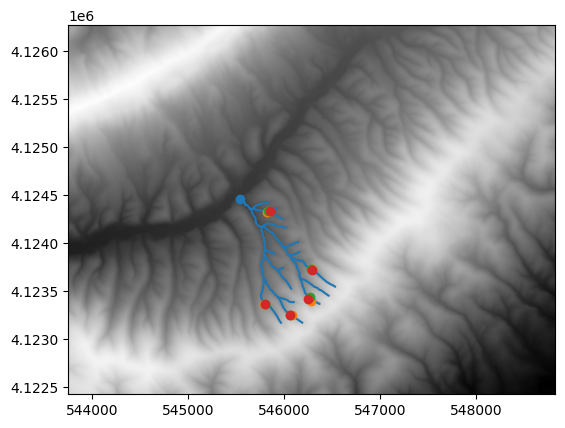

In [218]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
im = ax.imshow(dem, extent=grid.extent, zorder=2, norm=colors.LogNorm(dem.min(), dem.max()), interpolation='bilinear', cmap='Greys_r')
# c = ax.imshow(np.where(catch, catch, np.nan), extent=grid.extent, zorder=3, alpha=0.7, cmap='Greys')
for l in lines['features']:
    reach = np.asarray(l['geometry']['coordinates'])
    ax.plot(reach[:, 0], reach[:, 1], c='tab:blue')
ax.scatter(ppx, ppy, zorder=5)
s1_heads.plot(ax=ax, c='tab:orange', zorder=6)
s2_heads.plot(ax=ax, c='tab:green', zorder=7)
s3_heads.plot(ax=ax, c='tab:red', zorder=8)

<Axes: >

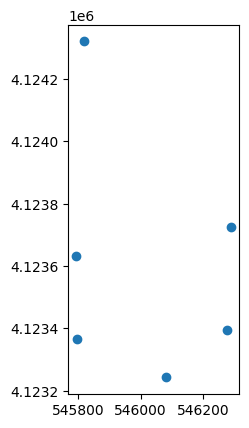

In [209]:
s1_heads.plot(c='tab:orange')

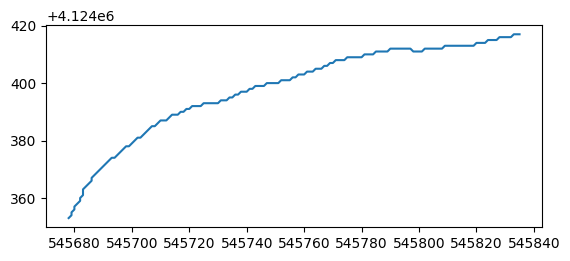

In [ ]:
fig, ax1 = plt.subplots()
for l in lines['features'][0:1]:
    reach = np.asarray(l['geometry']['coordinates'])
    ax1.plot(reach[:, 0], reach[:, 1], c='tab:blue')
    ax1.set_aspect('equal')

In [427]:
len(cs)

6

In [ ]:
t = LineString(reach)

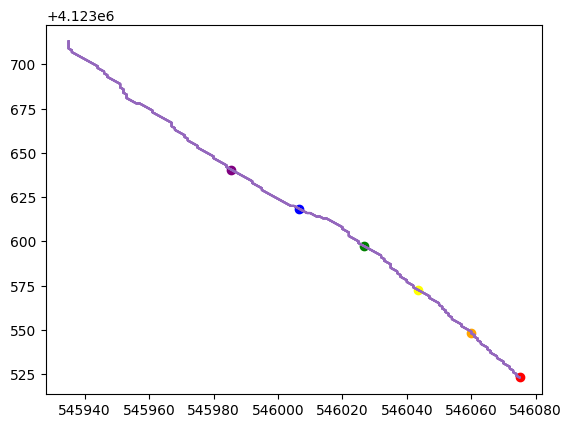

In [535]:

n = 10
t = mapped_reaches.loc[n:n]
x, y = t.geometry[n].xy
fig, ax2 = plt.subplots()

i = 0

cs = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
# mapped_reaches.plot(ax=ax2)
# channel_heads.plot(ax=ax2)
while i < len(cs):
    ax2.plot(x, y, color='tab:purple')
    px, py = t.geometry[n].interpolate(i * t.geometry[n].length / 8).xy
    ax2.scatter(px[0], py[0], color=(cs[i]))
    i += 1


In [492]:
print(mapped_reaches.loc[10].geometry.intersection(mapped_reaches.loc[9].geometry))

POINT (545934.99999 4123713.00002)


In [130]:
gdf = gpd.GeoDataFrame(lines['features'], crs=32617)[['id', 'geometry']]
gdf.to_file('/content/drive/MyDrive/field_data/flowlines.shp')

In [143]:
## map field reach ids to gdf ids

translator = {
    0: 'L',
    1: 'UNKNOWN', # ARTIFACT OF FLOW ACCUMULATION, NOT A CHANNEL
    2: 'O', # DRY
    3: 'M',
    4: 'K',
    5: 'K',
    6: 'UNKNOWN', # NOT MAPPED IN ANY SURVEY, LOOKED COLLUVIAL
    7: 'V',
    8: 'U',
    9: 'I', # NOT MAPPED IN ANY SURVEY, LOOKED COLLUVIAL
    10: 'Q', # DRY
    11: 'A',
    12: 'R', #JUST A SPRING, recorded 0 on survey 1 and width at spring on survey 2, not even mapped in 3. RECOMMEND EXCLUDE
    13: 'P',
    14: 'C',
    15: 'S', # DRY
    16: 'X', # DRY
    17: 'Y', # DRY
    18: 'W', # erroneously called C in first survey
    19: 'B',
    20: 'F',
    21: 'F',
    22: 'F',
    23: 'F',
    24: 'J',
    25: 'T',
    26: 'H',
    27: 'G',
    28: 'G',
    29: 'G',
    30: 'E',
    31: 'E',
    32: 'E'
}

gdf['reach'] = gdf['id'].map(translator)
gdf

,id,geometry,reach
0,0,"LINESTRING (545835 4124417, 545834 4124417, 54...",L
1,1,"LINESTRING (545598 4124390, 545598 4124391, 54...",UNKNOWN
2,2,"LINESTRING (545918 4124356, 545917 4124356, 54...",O
3,3,"LINESTRING (545986 4124249, 545985 4124249, 54...",M
4,4,"LINESTRING (545852 4124327, 545851 4124327, 54...",K
5,5,"LINESTRING (545678 4124353, 545677 4124353, 54...",K
6,6,"LINESTRING (546025 4124160, 546024 4124160, 54...",UNKNOWN
7,7,"LINESTRING (546147 4124009, 546146 4124008, 54...",V
8,8,"LINESTRING (546159 4123904, 546158 4123904, 54...",U
9,9,"LINESTRING (545901 4123884, 545900 4123884, 54...",I


In [410]:
reachlines = []
ridlist = ['A', 'B', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'P', 'R', 'T', 'W']
for rid in ridlist:
    reach = (line_merge(MultiLineString(gdf.loc[gdf.reach == rid].geometry.tolist())))

    reachlines.append(reach)
mapped_reaches = gpd.GeoDataFrame({'reach': ridlist, 'geometry': reachlines}, crs=32617)
# egdf = gpd.GeoDataFrame(geometry=[reach_e], crs=32617)
# egdf.plot()

In [411]:
# fig, ax = plt.subplots()
mapped_reaches
# confluences.plot(ax=ax)

,reach,geometry
0,A,"LINESTRING (546532 4123543, 546531 4123544, 54..."
1,B,"LINESTRING (546171 4123627, 546170 4123628, 54..."
2,E,"LINESTRING (545766 4124166, 545765 4124167, 54..."
3,F,"LINESTRING (546079 4123837, 546078 4123838, 54..."
4,G,"LINESTRING (545789 4123633, 545788 4123634, 54..."
5,H,"LINESTRING (545943 4123429, 545942 4123430, 54..."
6,J,"LINESTRING (545969 4123168, 545968 4123169, 54..."
7,K,"LINESTRING (545852 4124327, 545851 4124327, 54..."
8,M,"LINESTRING (545986 4124249, 545985 4124249, 54..."
9,P,"LINESTRING (545935 4123713, 545934 4123714, 54..."


In [417]:
confluences

,r1,r2,geometry
0,A,B,POINT (546079 4123837)
2,A,F,POINT (546079 4123837)
12,B,A,POINT (546079 4123837)
14,B,F,POINT (546079 4123837)
23,B,W,POINT (546171 4123627)
26,E,F,POINT (545766 4124166)
27,E,G,POINT (545766 4124166)
30,E,K,POINT (545651 4124352)
36,F,A,POINT (546079 4123837)
37,F,B,POINT (546079 4123837)


In [266]:
s1_pts = pd.read_csv('/content/drive/MyDrive/field_data/Waypoints_21-MAY-25.csv')
s1_pts = s1_pts.rename(columns={'ID': 'id'})
s1_pts.loc[0, 'id'] = 'T001'
s1_pts.loc[1, 'id'] = 'J001'
s1_pts.loc[2, 'id'] = 'J032'
s1_pts.loc[10, 'id'] = 'W001'
s1_pts = gpd.GeoDataFrame(s1_pts, geometry=gpd.points_from_xy(s1_pts.Easting, s1_pts.Northing, crs=32617)).set_index('id')
s1_heads = s1_pts.loc[['M001', 'J001', 'A001', 'W001', 'T001']][['geometry']]

s2_pts = gpd.read_file('/content/drive/MyDrive/field_data/Waypoints_04-JUN-25.gpx', layer='waypoints').to_crs(32617)
s2_pts = s2_pts.rename(columns={'name': 'id'})
s2_pts = s2_pts.set_index('id')
s2_heads = s2_pts[['geometry']].loc[['M001', 'J001', 'A001', 'W001', 'T001']]

s3_pts = gpd.read_file('/content/drive/MyDrive/field_data/Waypoints_18-JUN-25.gpx', layer='waypoints').to_crs(32617)
s3_pts = s3_pts.rename(columns={'name': 'id'})
s3_pts = s3_pts.set_index('id')
s3_heads = s3_pts[['geometry']].loc[['M001', 'J001', 'A001', 'W001', 'T001']]

merged_heads = s1_heads.merge(s2_heads, on='id', suffixes=('_s1', '_s2')).merge(s3_heads, on='id').rename(columns={'geometry': 'geometry_s3'})

headlist = []
idlist = []
for id in merged_heads.index:
    idlist.append(id)
    headlist.append(MultiPoint(merged_heads.loc[id].tolist()).centroid)

    channel_heads = gpd.GeoDataFrame({'id': idlist, 'geometry': headlist})

In [269]:
channel_heads['reach'] = channel_heads.apply(lambda row: row['id'][0], axis=1)
channel_heads

,id,geometry,reach
0,M001,POINT (545836.234 4124325.684),M
1,J001,POINT (545802.496 4123362.967),J
2,A001,POINT (546287.433 4123722.768),A
3,W001,POINT (546263.371 4123414.406),W
4,T001,POINT (546072.459 4123243.118),T


In [412]:
clist = []
r1s = []
r2s = []

for i1 in range(len(mapped_reaches)):
    for i2 in range(len(mapped_reaches)):
        if i1 != i2:
            l1 = mapped_reaches.loc[i1].geometry
            r1 = mapped_reaches.loc[i1].reach
            l2 = mapped_reaches.loc[i2].geometry
            r2 = mapped_reaches.loc[i2].reach

            c = l1.intersection(l2)

            clist.append(c)
            r1s.append(r1)
            r2s.append(r2)

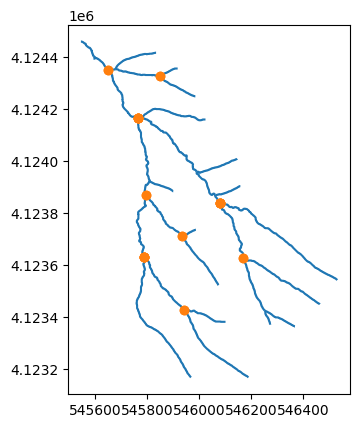

In [416]:
confluences = gpd.GeoDataFrame({'r1': r1s, 'r2': r2s, 'geometry': clist}, crs=32617)
confluences = confluences.loc[~(confluences.geometry.is_empty)]
fig, ax = plt.subplots()
gdf.plot(ax=ax, zorder=0)
confluences.plot(ax=ax, zorder=1, color='tab:orange')

confluences.to_file('/content/drive/MyDrive/field_data/confluences.shp')

In [421]:
# testreach =
ipoints = []
mapped_reaches.loc[0]

,0
reach,A
geometry,"LINESTRING (546531.99999 4123543.00002, 546530..."


In [560]:
widths = pd.read_csv('/content/drive/MyDrive/field_data/survey_20250604.csv')
widths = widths[['reach_id', 'meas_num', 'strahler_order', 'wet_in', 'dry_in']]
widths = widths.loc[widths.meas_num >= 0]
widths['site_id'] = widths.apply(lambda row: f'{row.reach_id}{int(row.meas_num):03d}', axis=1)
widths['wet_cm'] = widths.wet_in * 2.54
widths['dry_cm'] = widths.dry_in * 2.54
widths

,reach_id,meas_num,strahler_order,wet_in,dry_in,site_id,wet_cm,dry_cm
3,M,1.0,1,3.0,1.0,M001,7.62,2.54
4,M,2.0,1,0.0,NaN,M002,0.00,NaN
5,M,3.0,1,0.0,NaN,M003,0.00,NaN
6,M,4.0,1,0.0,NaN,M004,0.00,NaN
7,M,5.0,1,0.0,NaN,M005,0.00,NaN
...,...,...,...,...,...,...,...,...
420,B,19.0,2,0.0,NaN,B019,0.00,NaN
421,B,20.0,2,0.0,NaN,B020,0.00,NaN
422,B,21.0,2,0.0,NaN,B021,0.00,NaN
423,B,22.0,2,0.0,NaN,B022,0.00,NaN


In [570]:
reach_pts = []
for rid in ridlist:
    rwidths = widths.loc[widths.reach_id == rid]
    segment = mapped_reaches.loc[mapped_reaches.reach == rid].reset_index().geometry[0]

    nps = len(rwidths)
    pointlist = []
    interp_distance = segment.length / (nps + 1)
    for pnum in range(1, nps + 1):
        pointlist.append(segment.interpolate(pnum * interp_distance))


    reach_pts.append(gpd.GeoDataFrame({'geometry': pointlist, 'width': rwidths['wet_cm']}, crs=32617))


<Axes: >

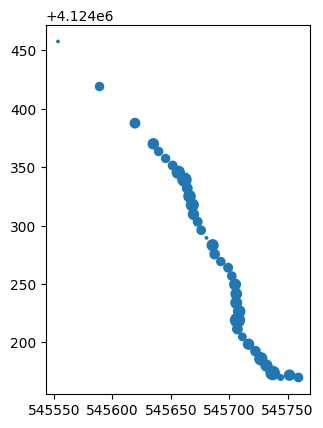

In [564]:
interps = gpd.GeoDataFrame({'geometry': pointlist, 'width': rwidths['wet_in']}, crs=32617)

k = mapped_reaches.loc[mapped_reaches.reach == 'A']

fig, ax = plt.subplots()
# k.plot(ax=ax)
interps.plot(ax=ax, markersize='width')

In [576]:
l, b, r, t = mapped_reaches.total_bounds

<Axes: >

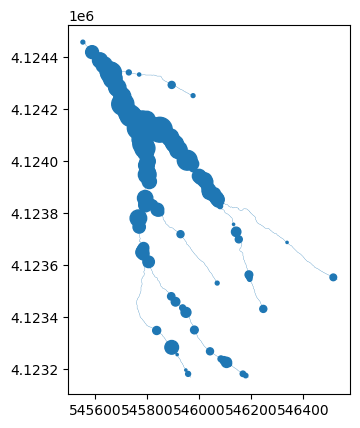

In [580]:

fig, ax = plt.subplots()
mapped_reaches.plot(ax=ax, linewidth=0.2, zorder=0)

# im = ax.imshow(dem, zorder=2, norm=colors.LogNorm(dem.min(), dem.max()), interpolation='bilinear', cmap='Greys_r')

pd.concat(reach_pts).plot(markersize='width', ax=ax, zorder=1)

# ax.set_xlim(l - 100, r + 100)
# ax.set_ylim(b - 100, b + 100)